## Transfer Learning on Flowers Dataset

<a href="https://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.pdf">Official Paper</a>&emsp;<a href="https://www.robots.ox.ac.uk/~vgg/data/flowers/102/">Official Page</a>&emsp;<a href="https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz">Download Dataset</a>&emsp;<a href="https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1">Download Labels</a>

---

#### Project Description
Although the idea of Deep Learning was born almost 80 years ago, we are just given the opportunity to bring any sophisticated ideas to life. That is why we will be looking at the extensively researched case of classfying 102 categories of flowers. Even though the task does not sound hard, the challenges arise in the similarity in both color and shape, which can be seen here:
<img src="images/shape_color.png" width="700px"/>

To elaborate on the topic of similarities, there are nine types of lilies (Giant White Arum, Fire, Water, Toad, Blackberry, Sword, Tiger, Peruvian, Canna) and two types of irises (Bearded, Yellow). Additional difficulties can be found with the non-conventional distribution of training (12.45%), validation (12.45%), and testing (75.1%) sets. 

The project will be worked around ResNet34 (34 convolutional layers) model which is a residual network that was trained on ImageNet's images. It is considerately smaller than most of the other models with only 20 million parameters. Thus, the training part will not take long even on CPU mode (from my findings, running 15 epochs takes around 40 minutes).
<img src="images/models.png" width="400px"/>

---

In this notebook I will attempt to experiment with different models and learning rate schedulers. However, the main task as stated by <a href="https://www.fellowship.ai/">fellowship.ai</a> is to apply discriminative learning rates. After researching on such an approach, I found out that differential were renamed to discriminative learning rates. This technique consists of changing the rates on each layer. To be more precise, it requires using smaller parameters on the base architecture, and bigger rates on the final fully connected layers. Therefore, there will be a lot of experimentation using this technique!
<img src="images/differential.png" width="450px"/>

### Table of Content:
* [Read the data](#read-data)
* [Success!](#success)
* [Create the loaders and Visualize](#create-loaders)
* [Discriminative Learning Rates](#discriminative)
* [Time to train our model!](#train)
* [Compare results](#compare)
* [Additional challenge](#challenge)
* [Predict on Unseen Data](#unseen)
* [Conclusion](#conclusion)

In [108]:
# import essential packages
import os
import json 

import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch import nn
import torchvision.models as models
from torch.nn import functional as F
from torchvision import transforms

# additional helper function to do behind the scene
import helper
import visualize
import train_test

# disable warning signs 
import warnings
warnings.filterwarnings('ignore')

# set an aesthetically pleasing theme
sns.set()

### Read the Data <a class="anchor" id="read-data">
The data provided by the fellowship-ai was presented in a huge folder with 8189 images along with text files containing training, test, and validation paths and their respective targets.  

<img src="images/structure.png" width="200px"/>
    
Instead of finding the formatted folders online, I decided to take some time to deal with formatting manually. The formatting is essential for further usage of ImageFolder and DataLoader to read, transform, and create batches of data. To be able to use these functions, we need to have the following folder structure:
```
root/class_1/xxx.jpg
root/class_1/xxy.jpg
root/class_1/xxz.jpg

root/class_2/123.jpg
root/class_2/nsdf3.jpg
root/class_2/asd932_.jpg
```

#### Steps:
* Read the content of three sets (train, test, and validation)
* Create a dataframe to store all paths and targets <b>if</b> 'jpg' folder exists (to transfer the images to correct folders)
* Increase the index of all DataFrames and Series by 1 (indexing starts from 1 in target column)
* Create two target dictionaries to store <i>number:column</i> and <i>column:number</i> for better visualization 
* Create folders and transfer images from 'jpg' to their respective folders
    
---
#### Explanations 
<b>Why create a DataFrame to store all paths and targets?</b> Since I'm manually creating the folders, there was the need to iterate over the whole file and transfer the images accordingly.<br>
<b>Why increase by 1?</b> While creating the dataframes, their indices automatically start from 0. During the visualization step, I saw that the labels were interpreted incorrectly. At that time I realized that indexing of targets in the MATLAB file start from 1. 


In [21]:
# read the paths and targets, store them in dataframes 
train_df = pd.read_csv('paths/train.txt', sep=' ', names=['path', 'idx'])
test_df = pd.read_csv('paths/test.txt', sep=' ', names=['path', 'idx'])
valid_df = pd.read_csv('paths/valid.txt', sep=' ', names=['path', 'idx'])

# check the number of images in each dataframe
for df, name in [(train_df, 'train'), (test_df, 'test'), (valid_df, 'validation')]:
    print(f'{name} contains {df.shape[0]} images')

train contains 1020 images
test contains 6149 images
validation contains 1020 images


In [22]:
# if the 'jpg' file exists, create a dataframe to store all paths and targets
if os.path.exists('jpg'):
    # MATLAB returns a tuple, we need the first value which stores the array of target indices
    labels = scipy.io.loadmat('paths/imagelabels.mat')['labels'][0]
    # get all filenames from 'jpg' directory
    dataset = os.listdir('jpg')
    # store both results in a dataframe
    df = pd.DataFrame({'path': dataset, 'target': labels})
    # create a dataframe to not break the code after folder creation 
    df.to_csv('paths/dataframe.csv', index=False)

# otherwise read the existing dataframe
else:
    df = pd.read_csv('paths/dataframe.csv')

# read the class names and increase index by 1 
classes = pd.read_csv('paths/class_names.txt', names=['target'])
classes.index += 1

# remove the unnecessary punctuation marks 
label_dict, label_inverse = labels_dict = helper.prettify(classes)

# check for correctness 
next(iter(label_dict.items()))

(1, 'Pink Primrose')

In [23]:
#### Main part to create and transfer images ####

# helper.create_folders(df)   ## uncomment if you need to create the folders

# transfer the images from "jpg" folder to their appropriate files 
# helper.transfer([train_df, test_df, valid_df], df)   ## uncomment to transfer images

### Success! <a class="anchor" id="success">
Now the folders are in the format that I initially wanted to work with. They have the following format: <br>
<img src="images/right_folder.png" width="300px"/>

However, there biggest issue is that PyCharm automatically sorts folders alphabetically. When I created the folders, I was using numbers to initialize them, thus the IDE did its intelligent thing to prettify the results by sorting them as <b>numbers</b>. When the DataLoader checks the structure, it reads them as <b>strings</b>. I had to manually create a holder which stores the DataLoader structure. It was done by writing this complex structure:<br>
<code>sorted([str(x) for x in df['target'].unique().astype('object').tolist()])</code><br>

<b>Let's break it down</b>:
1. Get the unique instances of target column (1-102);
2. Change the data type, so it is not a number anymore;
3. Turn pandas Series to list;
4. Convert each instances to string;
5. Sort alphabetically

As a result, we get the following <b>correct</b> structure which will be stored in "actual_order" variable:<br>
<code> 1, 10, 100, 101, 102, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 
    29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 
    52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 
    76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99</code>


#### Trials 
At the very beginning, I wanted to create a string representation of folders with their actual names. However, doing so increased the complexity of finding the label's patterns in the visualization step. It was labeling sunflowers as roses, wallflowers as orange dahlia, and so on. I was sure there was a bug that I failed to look at. And after around 18-25 hours, thanks to <a href='https://github.com/pytorch/vision/issues/714'>this reply</a>, everything made sense! Here's the initial folder screenshot:
<img src="images/wrong_folders.png" width="350px"/>

### Create the loaders and Visualize <a class="anchor" id="create-loaders"/>
Time to build the loaders and visualize the transformations applied to training set. To not clutter this page, all the instantiations happen <a href=''>here</a>. The following transformation were applied: <br>
<b>train</b>:
* Resize (226 pixels) & CenterCrop (224 pixels): ResNet34 requires the input images to have 224x224x3 dimensions (and just in general, all the pre-trained models require such input)
* RandomRotation by 10 degrees in both clockwise and anti-clockwise directions
* ToTensor: All the loaders have to be tensors
* Normalization: The standard form of mean (0.485, 0.486, 0.406) and standard deviation (0.229, 0.224, 0.225)

<b>test & validation</b>:<br>
All the transformations except for RandomRotation.

**Additional Remarks**: 
It's crucial to keep in mind the order of transformations. We cannot apply normalization before ToTensor, otherwise it will not work. Also, validation set cannot use the same transformation as training ones (because they're used for testing purposes as well). 
    
---
In order to visualize a batch, we need to un-normalize the data. The easiest way that I found to work is the following two-step transformation composition:
```
transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]), ])
```

In [24]:
# set the batch size
n_batches = 20

# create loaders with specified batch size
train_loader, test_loader, valid_loader = helper.create_loaders(n_batches)

# create an iterable from the train loader to easier visualize random batches
batch = iter(train_loader)

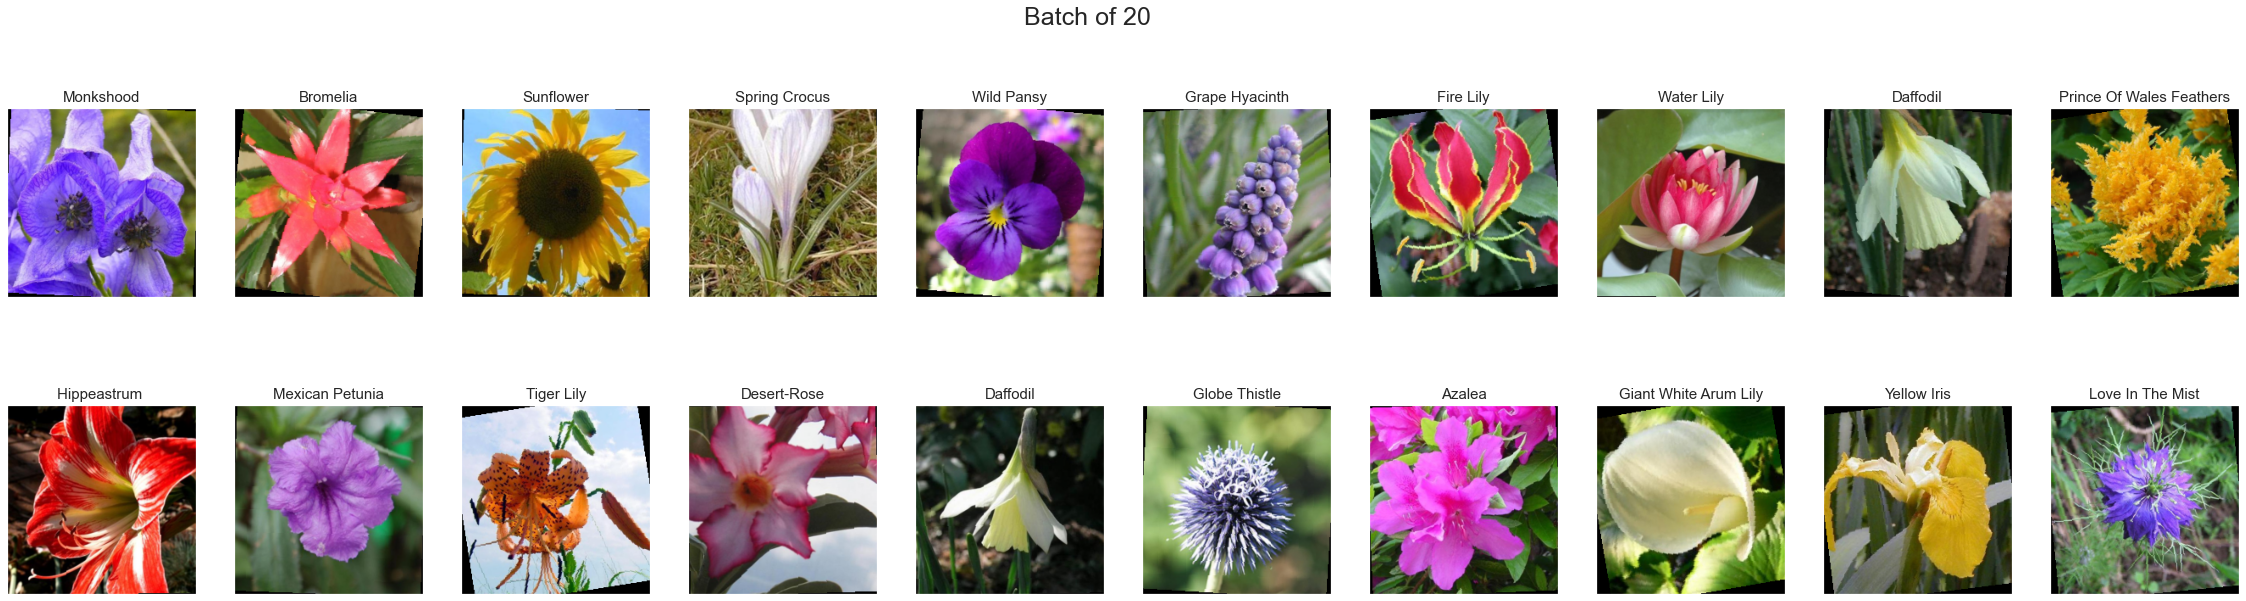

In [25]:
# get the correct labels (see "Success" section to learn about it)
actual_order = sorted([str(x) for x in df['target'].unique().astype('object').tolist()])
visualize.batch(batch, label_dict, n_batches, actual_order)

#### Visualize the distribution of flowers
Since we already know that there are 1020 instances in the training set, I want to check the number of images in each class. The importance of doing so is to see if there's a class imbalance that needs to be taken care of. As we see, there's an equal distribution of the images, which is incredible! We can now proceed to the next section.

In [26]:
visualize.hist(targets=label_dict)

There are 10 images in each folder


### Discriminative Learning Rates <a class="anchor" id="discriminative"/>
Discriminative Learning Rates is a common technique used in both Computer Vision and Natural Language Processing. The idea behind it is to use pre-trained parameters learned by a model, change it slightly while training, and apply major changes in the last fully connected layers (since we are not working with ImageNet's images). Finding a good model requires a lot of experimentation. That's why we'll be building four different instantiations and comparing the results. The architecture I decided to go with is written below (SGD example, the other ones can be found in "train_test.py"):
```
optimizer = optim.SGD([
    {'params': model.layer1.parameters(), 'lr': lr/10, 'momentum': 0.9, 'nesterov': True},
    {'params': model.layer2.parameters(), 'lr': lr/10, 'momentum': 0.9, 'nesterov': True},
    {'params': model.layer3.parameters(), 'lr': lr/10, 'momentum': 0.9, 'nesterov': True},
    {'params': model.layer4.parameters(), 'lr': lr/10, 'momentum': 0.9, 'nesterov': True},
    {'params': model.fc.parameters(), 'lr': lr, 'momentum': 0.9, 'nesterov': True}], 
    lr = lr, momentum=0.9, nesterov=True)
```

### Time to train our model! <a class="anchor" id="train"/>
This part is just to see how well the model does to make changes accordingly. There are three just-to-see-the-results initializations that I will be looking at: SGD (Stochastic Gradient Descent, 2 instances with different learning rates), Adagrad, and Adam optimizers along with an exponential learning rate scheduler. While choosing which optimizer to go with, I saw multiple opinions on them. It was quite biased, so I decided to give them all a try. Later on, we will compare the results :) 

However, let's still elaborate on the choice of the models.<br>
1. SGD + momentum + Nesterov<br>
Being inspired by <cite data-cite="sutskever2013importance">"On the importance of initialization and momentum in deep learning"</cite> [1], I'm using the SGD model along with momentum and Nesterov (which is also knows as Nesterov's Accelerated Gradient(NAG)). Momentum is a technique that helps gradient not to get stuck in a local minima by bouncing off. However, it still can overshoot sometimes. That's why we need to enable Nesterov to maximize the probability of finding the global minima. 
**Additional remark**: I'm still knew to the whole Deep Learning concept, that's why there are two initialization with different learning rates that were manually selected.

2. Adagrad <br>
Adagrad is a good optimizer that can be beneficial for not finetuning learning rates since it adapts them accordingly. It does so by making minimal changes on frequently occuring features, and large changes on the otherwise. One of the biggest disadvantages of this optimizer is the "the accumulation of the squared gradients in the denominator. Since every added term is positive, the accumulated sum keeps growing during training, causing the learning rate to shrink and becoming infinitesimally small" [2].

3. Adam <br>
Adam is also an adaptive learning rate optimization. As SGD, it has a possibility to run with momentum, which I used in the training. Additional unarguable advantage of it is the ability to work with noisy and/or sparce gradients. 

Let's see which model will be able to predict the best!

In [27]:
# set the best model's paths
sgd_path1 = f'models/sgd_momentum_lr1e-2.pt'
sgd_path2 = f'models/sgd_momentum_lr1e-3.pt'
adagrad_path = f'models/adagrad.pt'
adam_path = f'models/adam.pt'

# set the json paths
sgd_json1 = 'models/sgd_momentum1.json'
sgd_json2 = 'models/sgd_momentum2.json'
adagrad_json = 'models/adagrad.json'
adam_json = 'models/adam.json'

# store the results of different models
results = []

# set epochs and batches
epochs = 10
batches = 10

# transfer to CUDA if applicable
use_cuda = torch.cuda.is_available()

In [109]:
# create helper functions
def get_model():
    """
    This function instantiates a model for each iteration and final prediction visualization.
        :return: ResNet34 model with changed FC layer
    """
    # create a ResNet34 model
    model = models.resnet34(pretrained=True)
 
    # store the final input layer
    in_features = model.fc.in_features
    # change the last FC layer
    model.fc = nn.Linear(in_features, 102)

    # transfer the model to GPU if it's available
    if use_cuda:
        model = model.cuda()
    return model


def train_valid_test(learning_decay, optim_name, epochs, batches, save_path, json_path, idx, lr):
    """
    This function uses the helper function (created in "train_test.py") and instantiates a new model to train. Then, it
    saves all the results in a JSON file.
        :param learning_decay:  Whether to apply Learning Rate Decay Scheduler
        :param optim_name:      Name of the optimizer
        :param epochs:          Number of epochs to run
        :param batches:         Number of batches to create (for DataLoader)
        :param save_path:       Path to store best model parameters
        :param json_path:       Path to store overall results
        :param idx:             Index of "results" list
        :param lr:              Initial learning rates (default 0.01)
    """
    # get the model
    model =  get_model()
    
    # train, validate, and test the model
    train_loss, valid_loss, test_loss, model, confused_with, test_dict = train_test.set_params(
        epochs, model, label_dict, actual_order, use_cuda, save_path=save_path,
        learning_decay=learning_decay, optim_name=optim_name, n_batch=batches, lr=lr)
    
    # store the results
    results.append({'train_loss': train_loss, 'valid_loss': valid_loss, 'test_loss': test_loss,
                   'confused_with': confused_with, 'test_dict': test_dict, 'path': save_path,
                    'optim': optim_name, 'batch_size': batches})

    # save results to a JSON file
    with open(json_path, 'w') as file:
        json.dump(results[idx], file)


========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Epochs: 10
    Learning rate: 0.01
    Path: models/sgd_momentum_lr1e-2.pt
    
Validation loss decreased (inf --> 1.214341).  Saving model ...
Validation loss decreased (1.214341 --> 0.717249).  Saving model ...
Validation loss decreased (0.717249 --> 0.543540).  Saving model ...
Validation loss decreased (0.543540 --> 0.426952).  Saving model ...
Epoch: 5 	Training Loss: 0.047729 	Validation Loss: 0.424156
Validation loss decreased (0.426952 --> 0.424156).  Saving model ...
Validation loss decreased (0.424156 --> 0.402913).  Saving model ...
Validation loss decreased (0.402913 --> 0.384653).  Saving model ...
Validation loss decreased (0.384653 --> 0.373121).  Saving model ...
Epoch: 10 	Training Loss: 0.016335 	Validation Loss: 0.376772


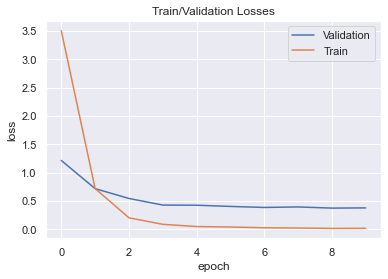

Test Loss: 0.446708


Test Accuracy: 88% (5449/6149)
========== Ending Training ==========
    Train loss: 0.01633549252223662
    Valid loss: 0.37677157933221145
    Test  loss: 0.4467083995351645
    


AttributeError: 'dict' object has no attribute 'append'

In [110]:
##############################
# Train using SGD optimizer #
#############################
# Momentum + Nesterov + 1e-2 LR 

train_valid_test(True, 'SGD', epochs, batches, sgd_path1, sgd_json1, 0, 0.01)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Epochs: 10
    Learning rate: 0.001
    Path: models/sgd_momentum_lr1e-3.pt
    
Validation loss decreased (inf --> 4.064176).  Saving model ...
Validation loss decreased (4.064176 --> 3.326040).  Saving model ...
Validation loss decreased (3.326040 --> 2.688247).  Saving model ...
Validation loss decreased (2.688247 --> 2.223456).  Saving model ...
Epoch: 5 	Training Loss: 1.897513 	Validation Loss: 1.824172
Validation loss decreased (2.223456 --> 1.824172).  Saving model ...
Validation loss decreased (1.824172 --> 1.552069).  Saving model ...
Validation loss decreased (1.552069 --> 1.347607).  Saving model ...
Validation loss decreased (1.347607 --> 1.220576).  Saving model ...
Validation loss decreased (1.220576 --> 1.119556).  Saving model ...
Epoch: 10 	Training Loss: 0.799596 	Validation Loss: 1.022141
Validation loss decreased (1.119556 --> 1.022141).  Saving model .

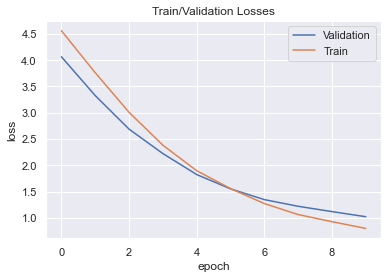

Test Loss: 1.148957


Test Accuracy: 80% (4938/6149)
========== Ending Training ==========
    Train loss: 0.7995957185824712
    Valid loss: 1.0221408707838433
    Test  loss: 1.1489574363561172
    


In [11]:
#################################
# Train using SGD optimizer #
#################################
# Momentum + Nesterov + 1e-3 LR 

train_valid_test(True, 'SGD', epochs, batches, sgd_path2, sgd_json2, 1, lr=0.001)

#### Adagrad insights
Before finding out how to correctly instantiate discriminative learning rates, I used a usual approach of running it with an exponential learning rate decay scheduler with initial rates being 0.01. The results of such structure were depressing, predicting only 23%. However, below we can see an incredible jump of over 61%! Below, you see both previous and current results.<br>
<img src="images/adagrad.png" width="500px"/>


========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: Adagrad
    Batch size: 10
    Epochs: 10
    Learning rate: 0.01
    Path: models/adagrad.pt
    
Validation loss decreased (inf --> 3.618944).  Saving model ...
Validation loss decreased (3.618944 --> 1.294781).  Saving model ...
Validation loss decreased (1.294781 --> 0.793650).  Saving model ...
Validation loss decreased (0.793650 --> 0.626352).  Saving model ...
Epoch: 5 	Training Loss: 0.173650 	Validation Loss: 0.602735
Validation loss decreased (0.626352 --> 0.602735).  Saving model ...
Validation loss decreased (0.602735 --> 0.550027).  Saving model ...
Validation loss decreased (0.550027 --> 0.512432).  Saving model ...
Validation loss decreased (0.512432 --> 0.507484).  Saving model ...
Validation loss decreased (0.507484 --> 0.499306).  Saving model ...
Epoch: 10 	Training Loss: 0.044645 	Validation Loss: 0.468871
Validation loss decreased (0.499306 --> 0.468871).  Saving model ...


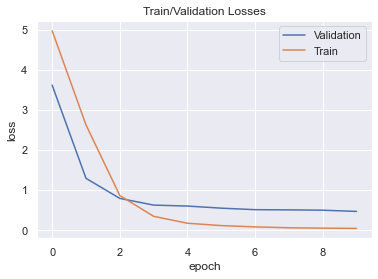

Test Loss: 0.527231


Test Accuracy: 86% (5335/6149)
========== Ending Training ==========
    Train loss: 0.04464520408096267
    Valid loss: 0.4688708297725694
    Test  loss: 0.5272309674540668
    


In [12]:
#################################
# Train using Adagrad optimizer #
#################################

train_valid_test(True, 'Adagrad', epochs, batches, adagrad_path, adagrad_json, 2, 0.01)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: Adam
    Batch size: 10
    Epochs: 10
    Learning rate: 0.0003
    Path: models/adam.pt
    
Validation loss decreased (inf --> 3.167897).  Saving model ...
Validation loss decreased (3.167897 --> 2.002525).  Saving model ...
Validation loss decreased (2.002525 --> 1.324589).  Saving model ...
Validation loss decreased (1.324589 --> 1.014849).  Saving model ...
Epoch: 5 	Training Loss: 0.513440 	Validation Loss: 0.791609
Validation loss decreased (1.014849 --> 0.791609).  Saving model ...
Validation loss decreased (0.791609 --> 0.700680).  Saving model ...
Validation loss decreased (0.700680 --> 0.647937).  Saving model ...
Validation loss decreased (0.647937 --> 0.597901).  Saving model ...
Validation loss decreased (0.597901 --> 0.567409).  Saving model ...
Epoch: 10 	Training Loss: 0.103075 	Validation Loss: 0.565983
Validation loss decreased (0.567409 --> 0.565983).  Saving model ...


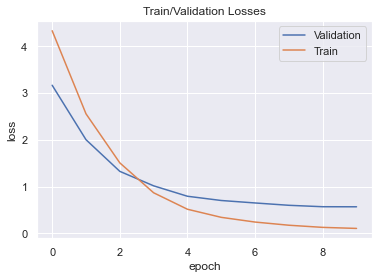

Test Loss: 0.619180


Test Accuracy: 87% (5354/6149)
========== Ending Training ==========
    Train loss: 0.10307544298177841
    Valid loss: 0.5659834810477846
    Test  loss: 0.6191795538959461
    


In [13]:
#################################
# Train using Adam optimizer #
#################################

train_valid_test(True, 'Adam', epochs, batches, adam_path, adam_json, 3, 0.0003)

### Compare results <a class="anchor" id="compare"/>
We see above that the results are pretty great, all of the models able to predict over 80% of the images. In comparison to the previous run without discriminative learning rates, the differences in best and worst models are only 7%, whereas the previous instantiation ranged in 64%. 

Our next step is to compare the results. Since I love visualizations and strongly believe that they can give better understanding, we will see multi-step approach. It will include the following:
* side-by-side visualizations
* top best and worst models' predictions on a test set's batch of 10 images
* top model's performance on the whole dataset, along with the worst prediction's confusions
* best and worst models' top 5 predictions on unseen data (after additional training at the end)

#### Additional Explanations
You might have noticed that I'm not freezing the parameters when instantiating the model. There was an interesting finding that not freezing them led to better results. As we saw earlier, Stochastic Gradient Descent's NAG version had pretty great results. However, when training a model with freezing, it scored 10% less. Therefore, I have decided to train all the models with ResNet34's unchanged parameters (except for the last fully-connected layer). Below, you can see the final outcomes: <br>
<img src="images/test2.png" width="500px" align="left"/>
<img src="images/test1.png" width="300px"/> 

In [31]:
# load results
with open(sgd_json1) as file:
    sgd_results = json.load(file)

with open(sgd_json2) as file:
    sgd_results2 = json.load(file)
    
with open(adagrad_json) as file:
    adagrad_results = json.load(file)

with open(adam_json) as file:
    adam_results = json.load(file)

# visualize training and validation values over epoch
visualize.side_by_side([sgd_results, sgd_results2, adagrad_results, adam_results], n_plots=4,
                       names=['SGD 0.01LR', 'SGD 0.001LR', 'Adagrad', 'Adam'])

In case github fails to show plotly images, here are the visualizations:
<img src="images/side_by_side.png" width="700px"/>

In [32]:
def visualize_final_results(path):
    """
    This function visualizes a batch of images with their correctly/incorrectly classified labels.
        :param path: Path to a saved model
    """
    # get a model
    model = get_model()
    # load the best performance of it
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    # visualize correctly/incorrectly classified images
    visualize.batch(iter(test_loader), label_dict, 10, actual_order, use_cuda, model=model)

def visualize_confusion(results):
    """
    This function visualizes all classes and their accuracies
        :param results: Dictionary storing all parameters (taken from JSON file)
    :return: Two ordered dictionaries with best and worst accuracies
    """
    # call a function to visualize accuracies
    first_half, second_half = visualize.show_test_results(results['test_dict'])
    return [first_half, second_half]
    
def most_confused(results, second_half, top_k):
    """
    This function visualizes model's worst performance on K classes. It shows a random image of the class that's being
    selected and K classes it confused with. It includes both histogram and image representation. The histogram version
    shows the exact times the model confused a specific class.
        :param results:         Dictionary that stores all information (read from a JSON file)
        :param second_half:     Dictionary of the worst performances
        :param top_k:           Number of classes to show
    :return:
    """
    # visualize most confused
    confused = visualize.get_confusions(results['confused_with'], label_dict, actual_order)

    # get the last K classes to show images of
    last_n = second_half.iloc[-top_k:, 0].to_list()

    # show random images of confused classes
    for last in last_n:
        visualize.visualize_most_confused(last, confused, label_inverse=label_inverse)

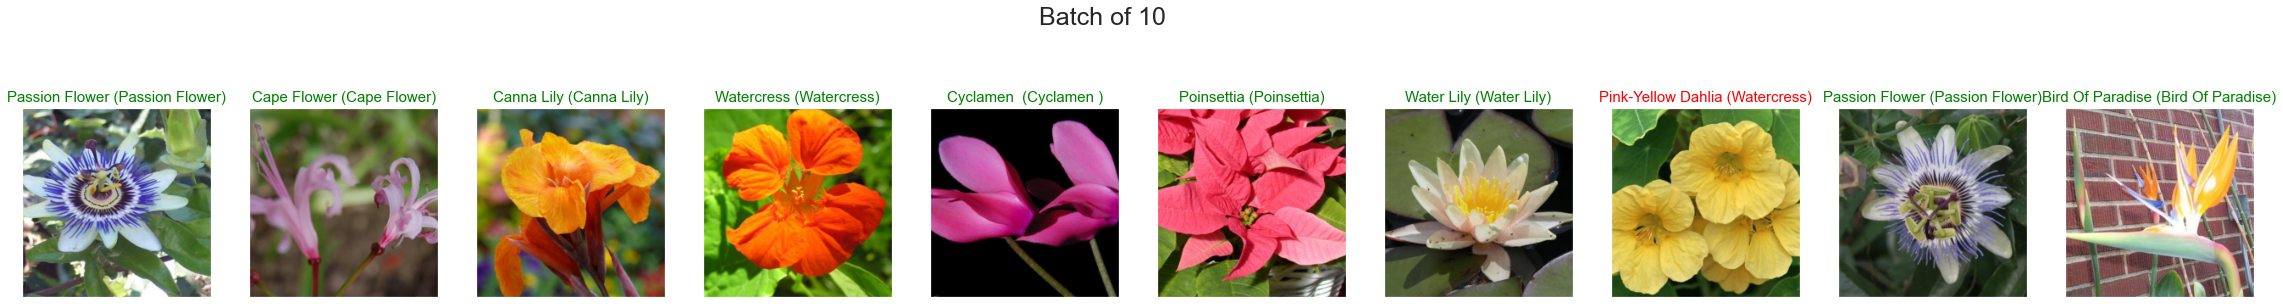

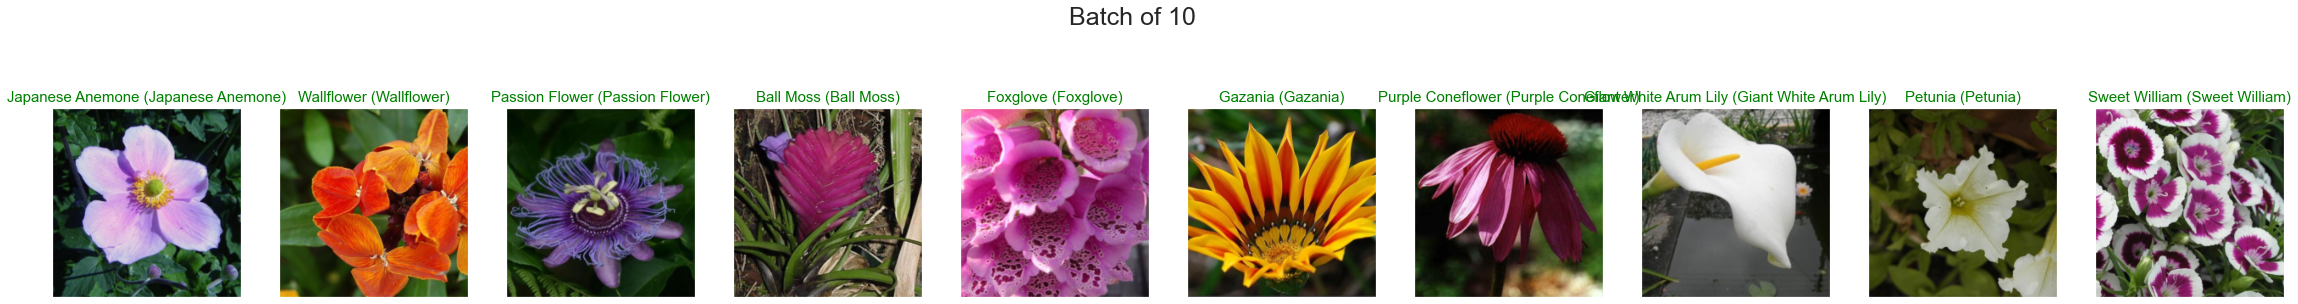

In [33]:
# visualize predictions for best and worst models 
visualize_final_results(adam_path)
visualize_final_results(sgd_path2)

In [34]:
# visualize best and worst class prediction of the best model 
_, second_half = visualize_confusion(adam_results)

In case github fails to show plotly images, here are the visualizatons:
<img src="images/top_bottom.png" width="800px"/> ![](attachement:images/top_bottom.png)

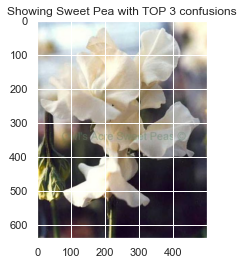

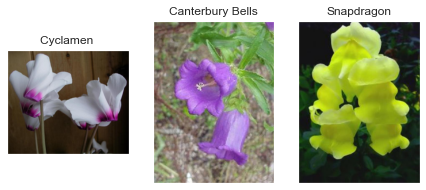

In [35]:
# show one class that is predicted the worst (Columbine was correctly classified by only 42%)
most_confused(adam_results, second_half, 1)

In case github fails to show plotly images, here are the visualizatons:
<img src="images/conf.png" width="700px"/> ![](attachement:images/conf.png)
<img src="images/flowers.png" width="700px"/> ![](attachement:images/flowers.png)

### Additional challenge <a class="anchor" id="challenge"/>
Both Stochastic Gradient Descent (with starting 1e-3 learning rate) and Adam optimizers scored similarly, with difference in 1%. However, Adagrad performed the worst, losing to its opponents by almost 60%. In this following section, I want to introduce additional challenge by using more transformations. 

After spending some days going through state-of-the-art research papers on image preprocessing, the one that caught my attention was "Transformation pursuit for image classification" [3] and "Automated flower classification over a large number of classes" [4]. The first paper proposes a subset of transformations: cropping, homography, scaling, colorimetry, JPEG compression, rotation, and Order-K. The second, however, mentions an amazing technique of "foreground-segmentation". Since the segmentation technique requires advanced knowledge of Computer Vision, I've decided to put off the idea until I get to that level. However, the first one is doable but some modifications need to be applied. The paper mentions "colorimetry" which is changing colometric values by computing the "covariance matrix of RGB components of the whole dataset". After running it on NAG, I saw that the test results were almost identical as in Adagrad example. Then only I understood that some flowers are distinguished by color only. Changing it will only worsen the situation with classifications. So, I've decided to go with the following set of transformations (I will include the ones that are altered or newly introduced):
* Random rotation by 30 degrees both directions
* Random vertical flip with 70% probability
* Random perspective: performs a random perspective transformation with 30% probability
* Random posterization: reduces the bits of color channels 


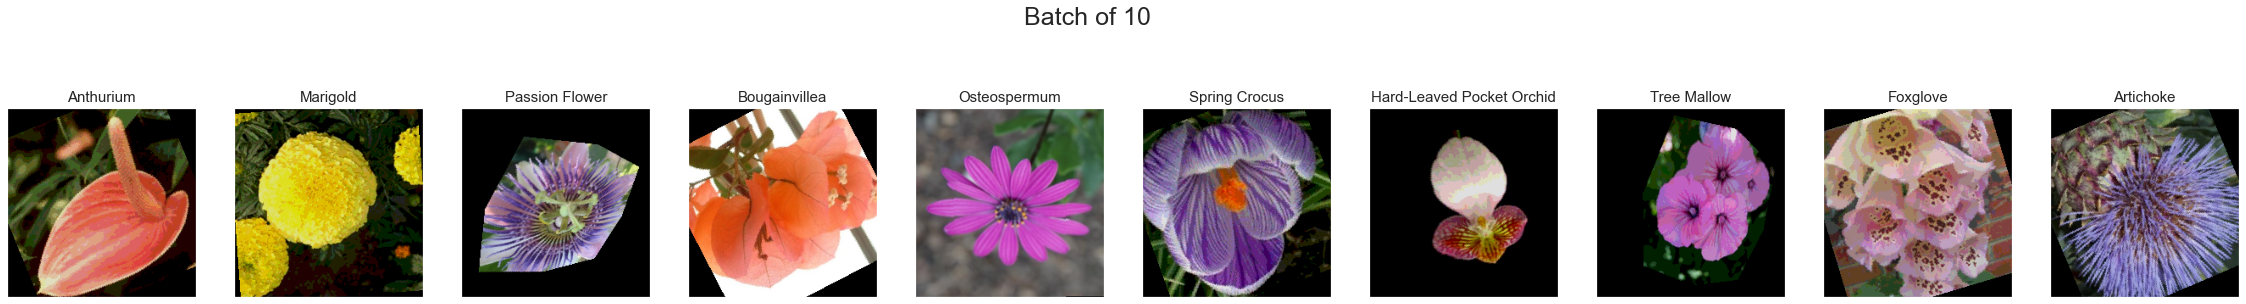

In [44]:
# define custom transformations
transformations = {
    # create separate transformations for training set
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(p=0.7),
        transforms.RandomPerspective(p=0.3),
        transforms.RandomPosterize(bits=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    # create separate transformations for test and validation sets
    'test_valid': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# get the model
model = get_model()
# specify the path to store best models at 
path = f'models/sgd_more_transforms2.pt'
# visualize the new transformations
train_loader, _, _ = helper.create_loaders(10, transformations)
visualize.batch(iter(train_loader), label_dict, 10, actual_order)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Epochs: 10
    Learning rate: 0.01
    Path: models/sgd_more_transforms2.pt
    
Validation loss decreased (inf --> 2.013866).  Saving model ...
Validation loss decreased (2.013866 --> 1.323316).  Saving model ...
Validation loss decreased (1.323316 --> 1.039908).  Saving model ...
Validation loss decreased (1.039908 --> 0.767262).  Saving model ...
Epoch: 5 	Training Loss: 0.348976 	Validation Loss: 0.702542
Validation loss decreased (0.767262 --> 0.702542).  Saving model ...
Validation loss decreased (0.702542 --> 0.656135).  Saving model ...
Validation loss decreased (0.656135 --> 0.613708).  Saving model ...
Validation loss decreased (0.613708 --> 0.553426).  Saving model ...
Epoch: 10 	Training Loss: 0.087345 	Validation Loss: 0.537131
Validation loss decreased (0.553426 --> 0.537131).  Saving model ...


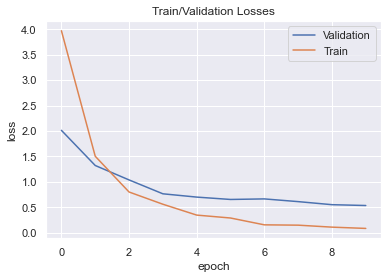

Test Loss: 0.615874


Test Accuracy: 84% (5190/6149)
========== Ending Training ==========
    Train loss: 0.08734471745350782
    Valid loss: 0.5371305440853843
    Test  loss: 0.6158735519699089
    


In [45]:
# train the new model
train_loss, valid_loss, test_loss, model, confused_with, test_dict = train_test.set_params(
        10, model, label_dict, actual_order, use_cuda, save_path=path, learning_decay=True, 
        optim_name='SGD', n_batch=10, transformations=transformations, lr=0.01)

# append the results 
results = {'train_loss': train_loss, 'valid_loss': valid_loss, 'test_loss': test_loss,
                   'confused_with': confused_with, 'test_dict': test_dict, 'path': path,
                    'optim': 'SGD', 'batch_size': 10}

# store the results in a json file 
with open('models/sgd3_results.json', 'w') as file:
    json.dump(results, file)

### Predict on Unseen Data <a class="anchor" id="unseen"/>

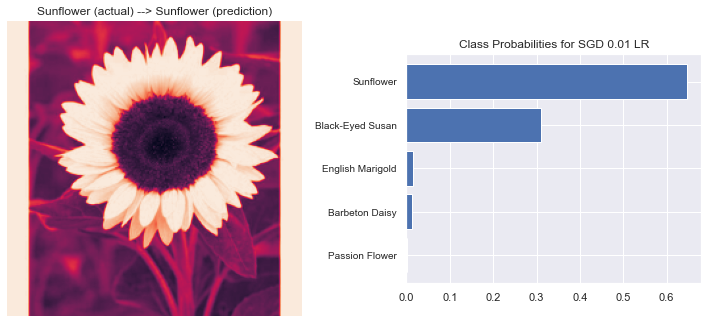

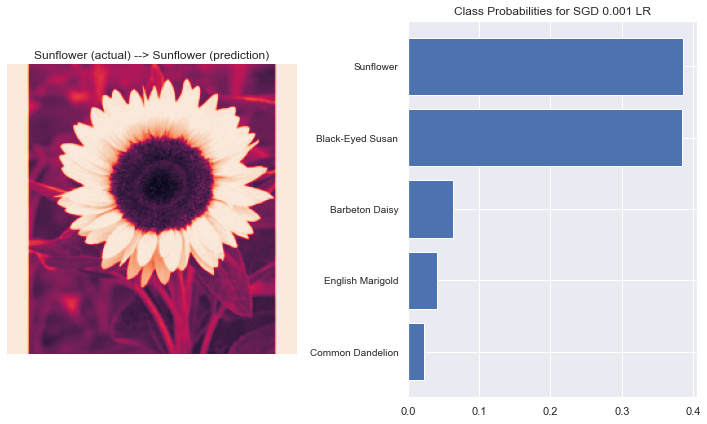

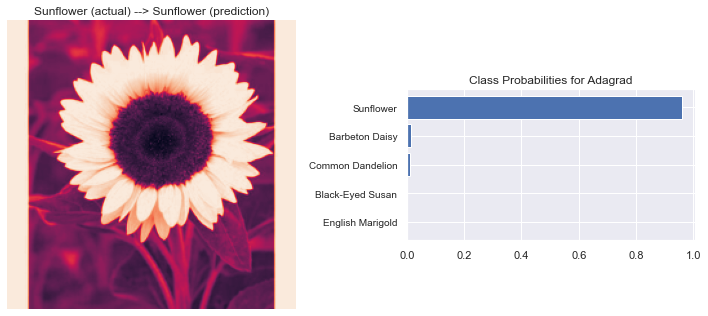

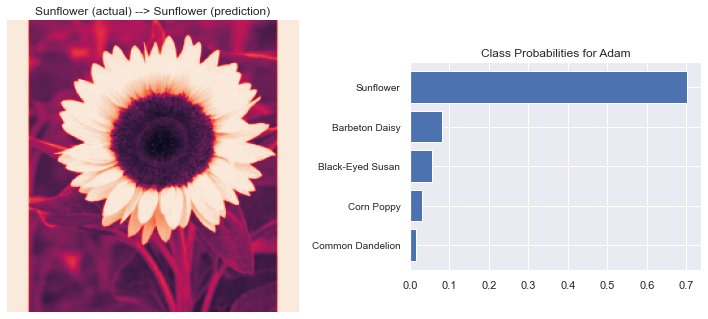

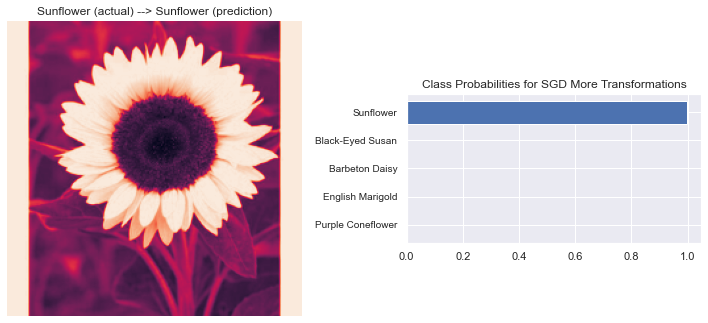

In [107]:
def predict_k(model, model_name):
    """
    This function shows every model's performance on unseen new image. It shows the original file as well as their
    TOP 5 predictions.
        :param model:       Specific model with best parameters
        :param model_name:  Name of the model (for title)
    :return:
    """
    # create transformations (all images must be transformed before feeding to the model)
    transformations = transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    # define un-normalization to restore original image
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]), 
    ])

    # read and apply transformations
    img = transformations(Image.open('images/test/54/sun.jpg')).unsqueeze_(0)
    # change the model to evaluation mode
    model.eval()
    # get probabilities
    output = F.softmax(model(img), dim=1)
    # get 5 classes with highest probabilities
    topk = torch.topk(output, 5)
    # transform predictions to numpy representation
    predictions = topk.indices.data.numpy().squeeze()
    # get actual names of predictions
    predictions = [label_dict[int(actual_order[x])] for x in predictions]

    # transform probabilities to numpy
    probabilities = topk.values.data.numpy().squeeze()
    # un-normalize the image
    image = unnormalize(img)

    # start plotting images and predictions side-by-side
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)
    # show the image
    ax1.imshow(image.resize_(1, 224, 224).numpy().squeeze())
    # remove axis
    ax1.axis('off')
    # set title in the form of target -- prediction
    ax1.set_title(f'Sunflower (actual) --> {predictions[0]} (prediction)')

    # plot probabilities using horizontal barplot
    ax2.barh(np.arange(5), probabilities)
    ax2.set_aspect(0.1)
    # set yticks
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(predictions, size='small')
    # show top-bottom predictions
    ax2.invert_yaxis()

    # set the title of predictions
    ax2.set_title(f'Class Probabilities for {model_name}')
    # squeeze for prettier representation
    plt.tight_layout()
    fig.show()


def load_model(path):
    """
    This function loads the model from scratch and reads the best model provided.
        :param path: Path to a model
    :return: Model of the specific architecture
    """
    model = get_model()
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model


# show predictions for the first SGD 0.01 LR model
predict_k(load_model(sgd_path1), 'SGD 0.01 LR')

# show predictions for the second SGD 0.001 LR model
predict_k(load_model(sgd_path2), 'SGD 0.001 LR')

# show predictions for the third Adagrad model
predict_k(load_model(adagrad_path), 'Adagrad')

# show predictions for the fourth Adam 0.model 
predict_k(load_model(adam_path), 'Adam')

# show predictions for the last model with more transformations
predict_k(load_model(path), 'SGD More Transformations')

### Conclusion <a class="anchor" id="conclusion"/>

Today we looked at the classification task where we needed to predict flowers from 102 categories. First, we manually
created all folders, iterated over each image and transferred them to correct folders. Second, we applied state-of-the-art
image preprocessing transformations and visualized them. Next, we trained four different models on ResNet34 pre-trained
network using discriminative learning rates. Then, we compared the results and found out which hyper-parameters performed best. Additionally, applied harder transformations to see whether it will solve the problem of overfitting. This step was very useful because we saw that even changing the colors by posterization, the model was able to have same results as the best-performing ones. We also looked at various visualizations and saw which classes were correctly and incorrectly classified. On top of that, we took a closer look at the mislabeled class and saw where the models failed to distinguish the differences.

As for further development strategies, I want to spend more time on foreground segmentation to see whether it gives
better classification. Also, even though we had a very good performance of 87%, I believe it's not the limit. To obtain
better results, we for sure need to have more images, time, and research hours. I wonder how the results will differ
if we switch training and test folders contents and follow a more conventional split of feeding 75% to the training set.

### Reference
[1] Sutskever, Ilya, et al. "On the importance of initialization and momentum in deep learning." International conference on machine learning. PMLR, 2013. <br>
[2] Lydia, Agnes, and Sagayaraj Francis. "Adagrad—an optimizer for stochastic gradient descent." Int. J. Inf. Comput. Sci 6.5 (2019). <br>
[3] Paulin, Mattis, et al. "Transformation pursuit for image classification." Proceedings of the IEEE conference on computer vision and pattern recognition. 2014. <br>
[4] Nilsback, Maria-Elena, and Andrew Zisserman. "Automated flower classification over a large number of classes." 2008 Sixth Indian Conference on Computer Vision, Graphics & Image Processing. IEEE, 2008.